# Interactive feature matching

In [25]:
import sys
sys.path.append('..')

from multiview_stitcher import spatial_image_utils as si_utils

from muvis_align.MVSRegistration import MVSRegistration
from muvis_align.util import dir_regex, print_dict_xyz
from muvis_align.image.util import get_sim_physical_size, draw_keypoints_matches

## Setup parameters

In [26]:
params = {
	'general':
	{
        'ui': 'mpl',
        'debug': True
	},
	'operations':
	[
		{
			'operation': 'register',
			'input': 'D:/slides/EM04652-02_slice17_spaghettiandmeatballs2/**/*_s00012.ome.tif',
			'source_metadata': 'sbem',
            'gaussian_sigma': 0.5,
            #'use_orthogonal_pairs': True,
            'n_parallel_pairwise_regs': 1,
			'output': '../../output/'
		}
	]
}


## Initialise muvis-align, initialise sims, and pre-process

In [27]:
operation_params = params['operations'][0]
filenames = dir_regex(operation_params['input'])

reg = MVSRegistration(params['general'])
reg.init_operation('', filenames, operation_params)
sims = reg.init_sims()

for label, sim in zip(reg.file_labels, sims):
    print(label,
          'pos:', print_dict_xyz(si_utils.get_origin_from_sim(sim), decimals=1, as_tuple=True),
          'scale:', print_dict_xyz(si_utils.get_spacing_from_sim(sim), as_tuple=True),
          'size:', print_dict_xyz(get_sim_physical_size(sim), decimals=1, as_tuple=True),
          'shape:', sim.shape)

norm_sims, _ = reg.preprocess(sims, operation_params)

for label, sim in zip(reg.file_labels, norm_sims):
    print(label,
          'pos:', print_dict_xyz(si_utils.get_origin_from_sim(sim), decimals=1, as_tuple=True),
          'scale:', print_dict_xyz(si_utils.get_spacing_from_sim(sim), as_tuple=True),
          'size:', print_dict_xyz(get_sim_physical_size(sim), decimals=1, as_tuple=True),
          'shape:', sim.shape)

ov000 pos: -260.9 -512.2 scale: 0.249 0.249 size: 1020.5 765.4 shape: (1, 1, 3072, 4096)
r0021_t0000 pos: 338.5 -92.3 scale: 0.010 0.010 size: 41.0 30.7 shape: (1, 1, 3072, 4096)
ov000 pos: -260.9 -512.2 scale: 0.249 0.249 size: 1020.5 765.4 shape: (1, 1, 3072, 4096)
r0021_t0000 pos: 338.5 -92.3 scale: 0.249 0.249 size: 40.9 30.6 shape: (1, 1, 123, 164)


## Get overlap between tiles

Overlap size [um]: [30.64566964 40.86089286]


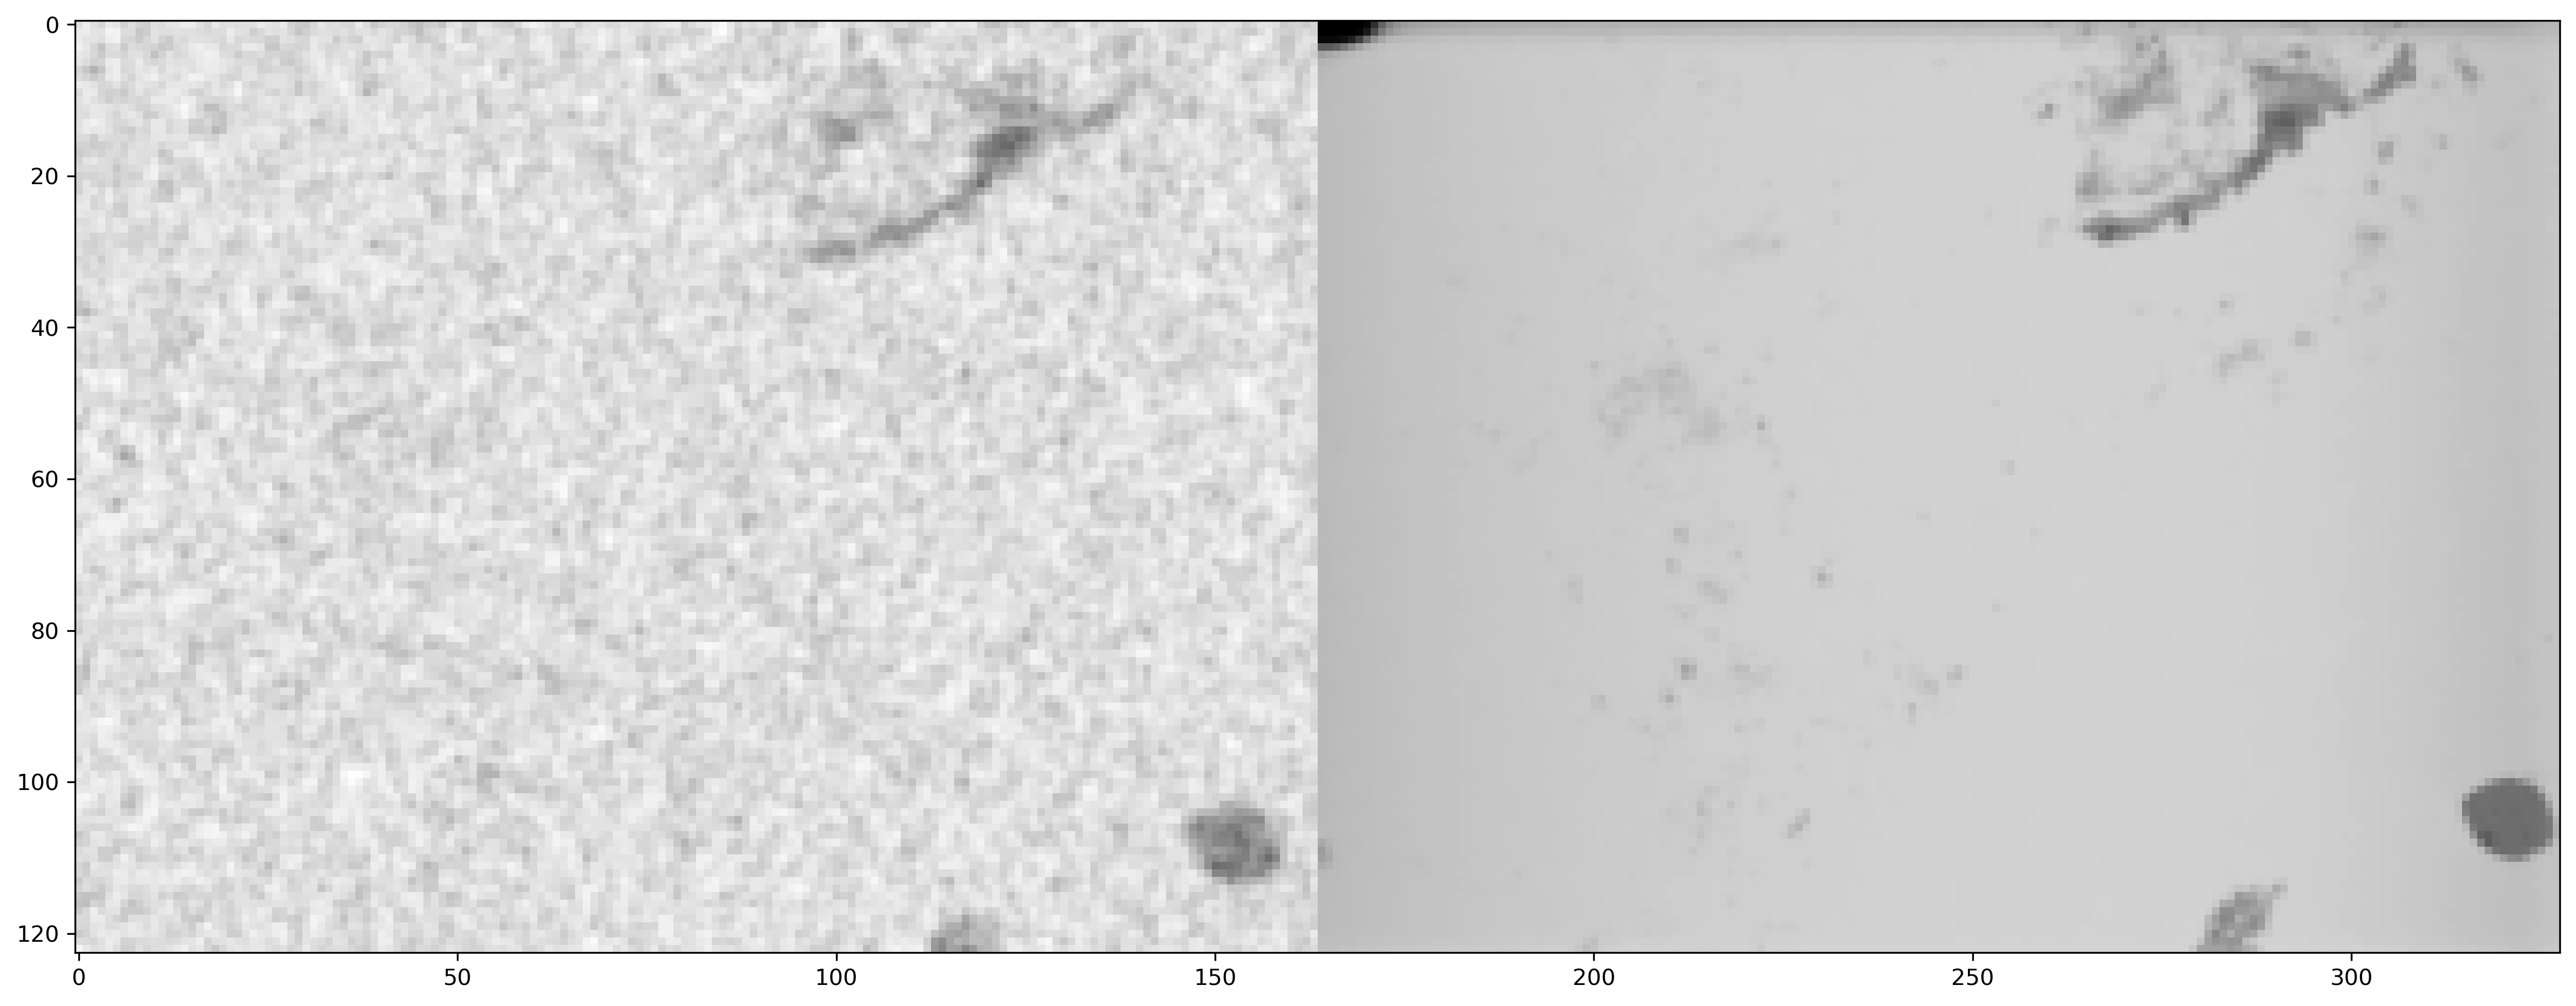

In [28]:
%matplotlib inline
overlap1, overlap2 = reg.get_overlap_images(norm_sims[0], norm_sims[1], reg.source_transform_key)
#overlap1, overlap2 = overlap1.squeeze().compute(), overlap2.squeeze().compute()
overlap1, overlap2 = overlap1.squeeze(), overlap2.squeeze()
print('Overlap size [um]:', overlap1.shape * si_utils.get_spacing_from_sim(sims[0], asarray=True))

fig, ax = draw_keypoints_matches(overlap1, [], overlap2, [])

## Interactive: Set up feature extraction and matching, and show results

### You can modify the parameters and rerun this cell to update results, e.g.:

**transform_type**: affine, euclidean, translation

**name**: sift, orb

In [29]:
reg.params.update({
    'transform_type': 'affine',
    'method': {
        'name': 'sift',	# 'sift' or 'orb'
        'max_keypoints': 5000,
        'inlier_threshold_factor': 0.05,
        'max_trials': 1000,
        'ransac_iterations': 3
    }
})

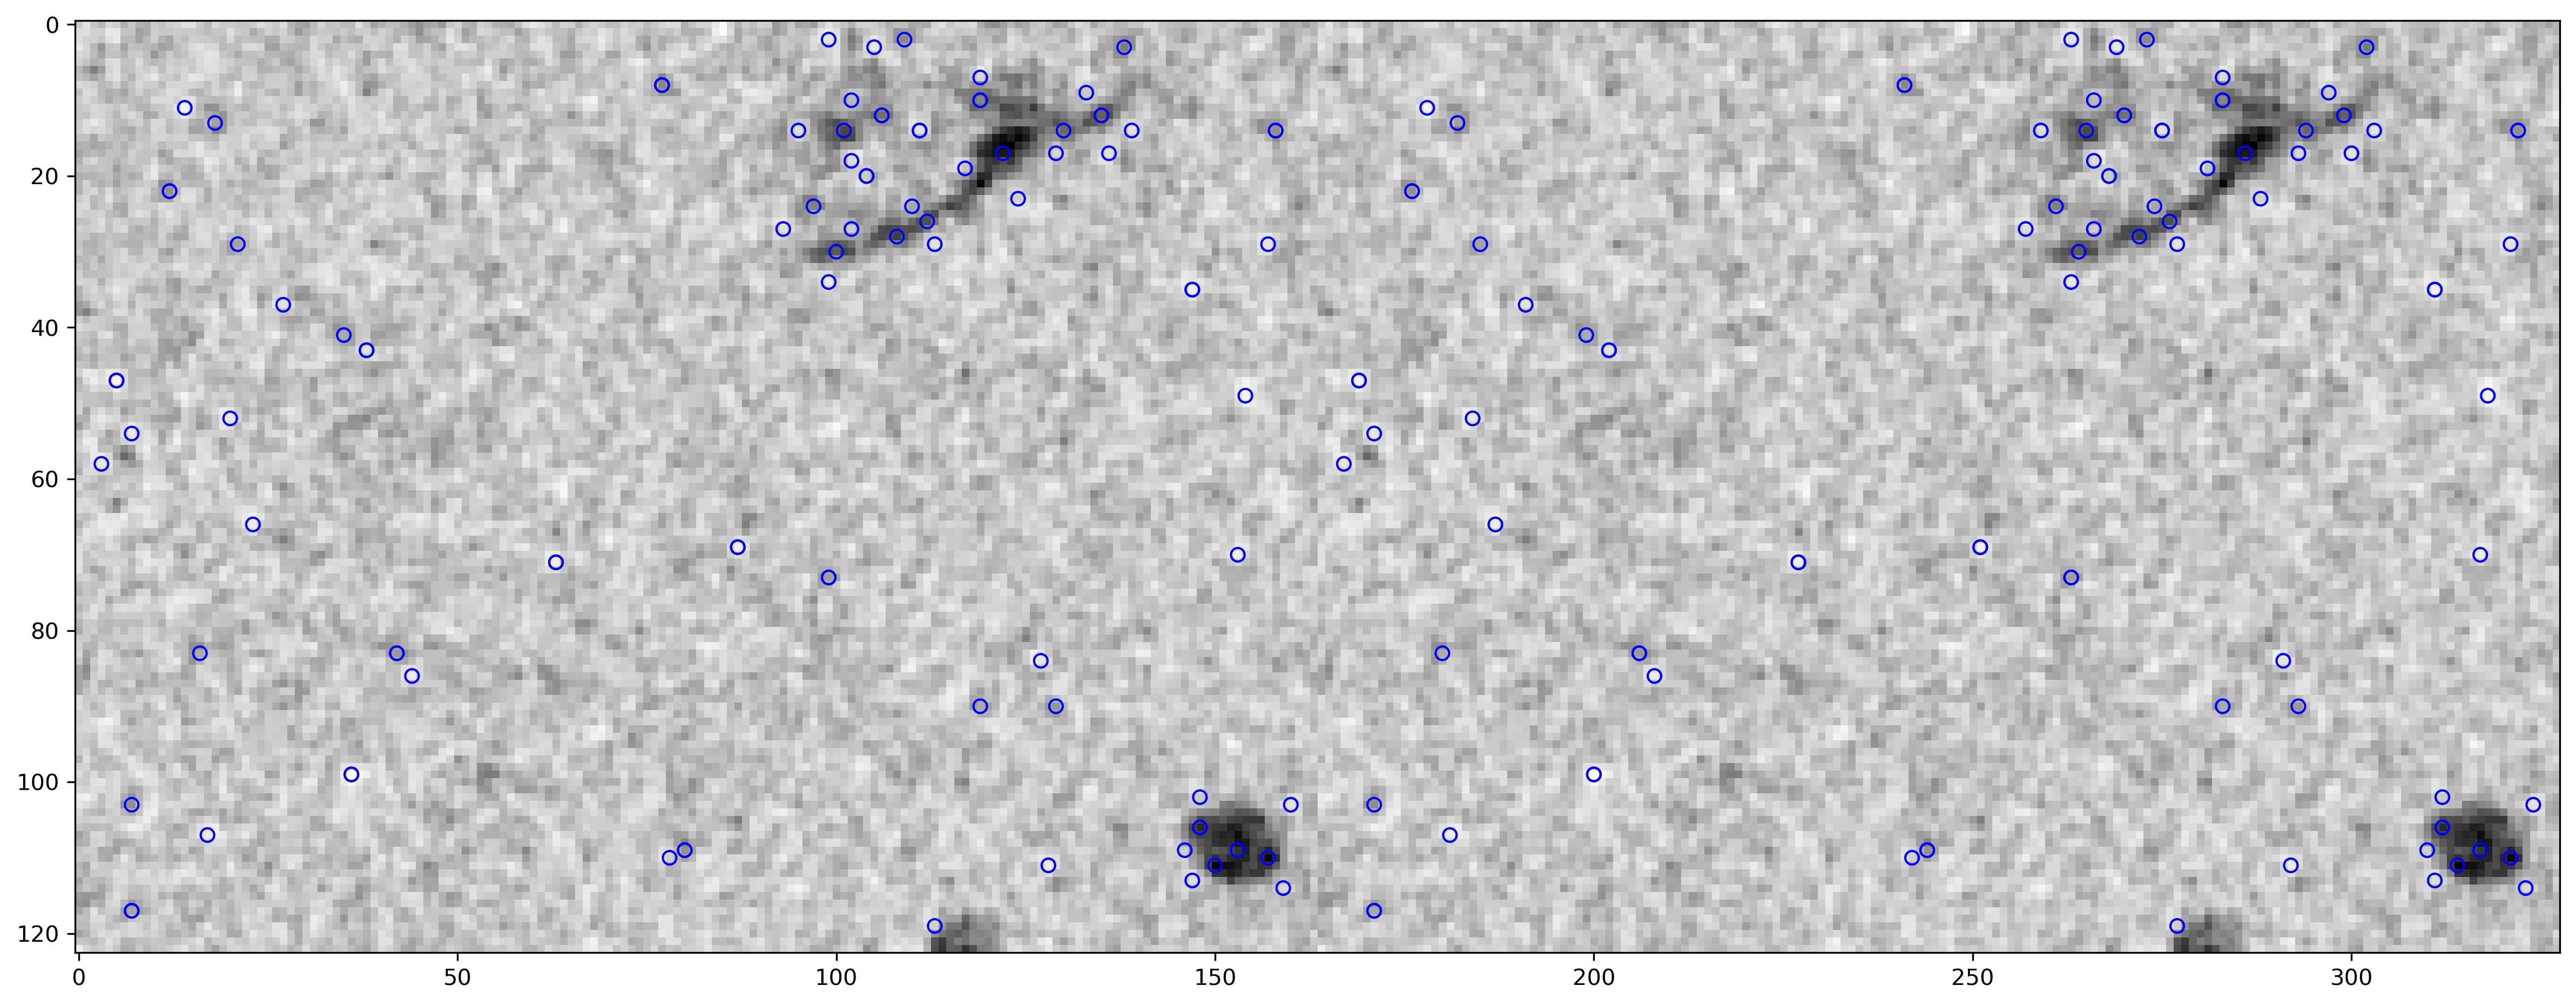

#keypoints: 96


In [30]:
%matplotlib inline

reg_method, pairwise_reg_func, pairwise_reg_func_kwargs = reg.create_registration_method(sims[0])
points, desc, data = reg.registration_method.detect_features(overlap1, gaussian_sigma=0)
draw_keypoints_matches(data, points, data, points, points_color='blue')
print(f'#keypoints: {len(points)}')

norm translation [-0.02440493  0.02630026] norm SD 0.0
%inliers 0.7857142857142857 #good ransac iterations 3
#keypoints: 96,28 #matches: 14 #inliers: 11 quality: 0.130


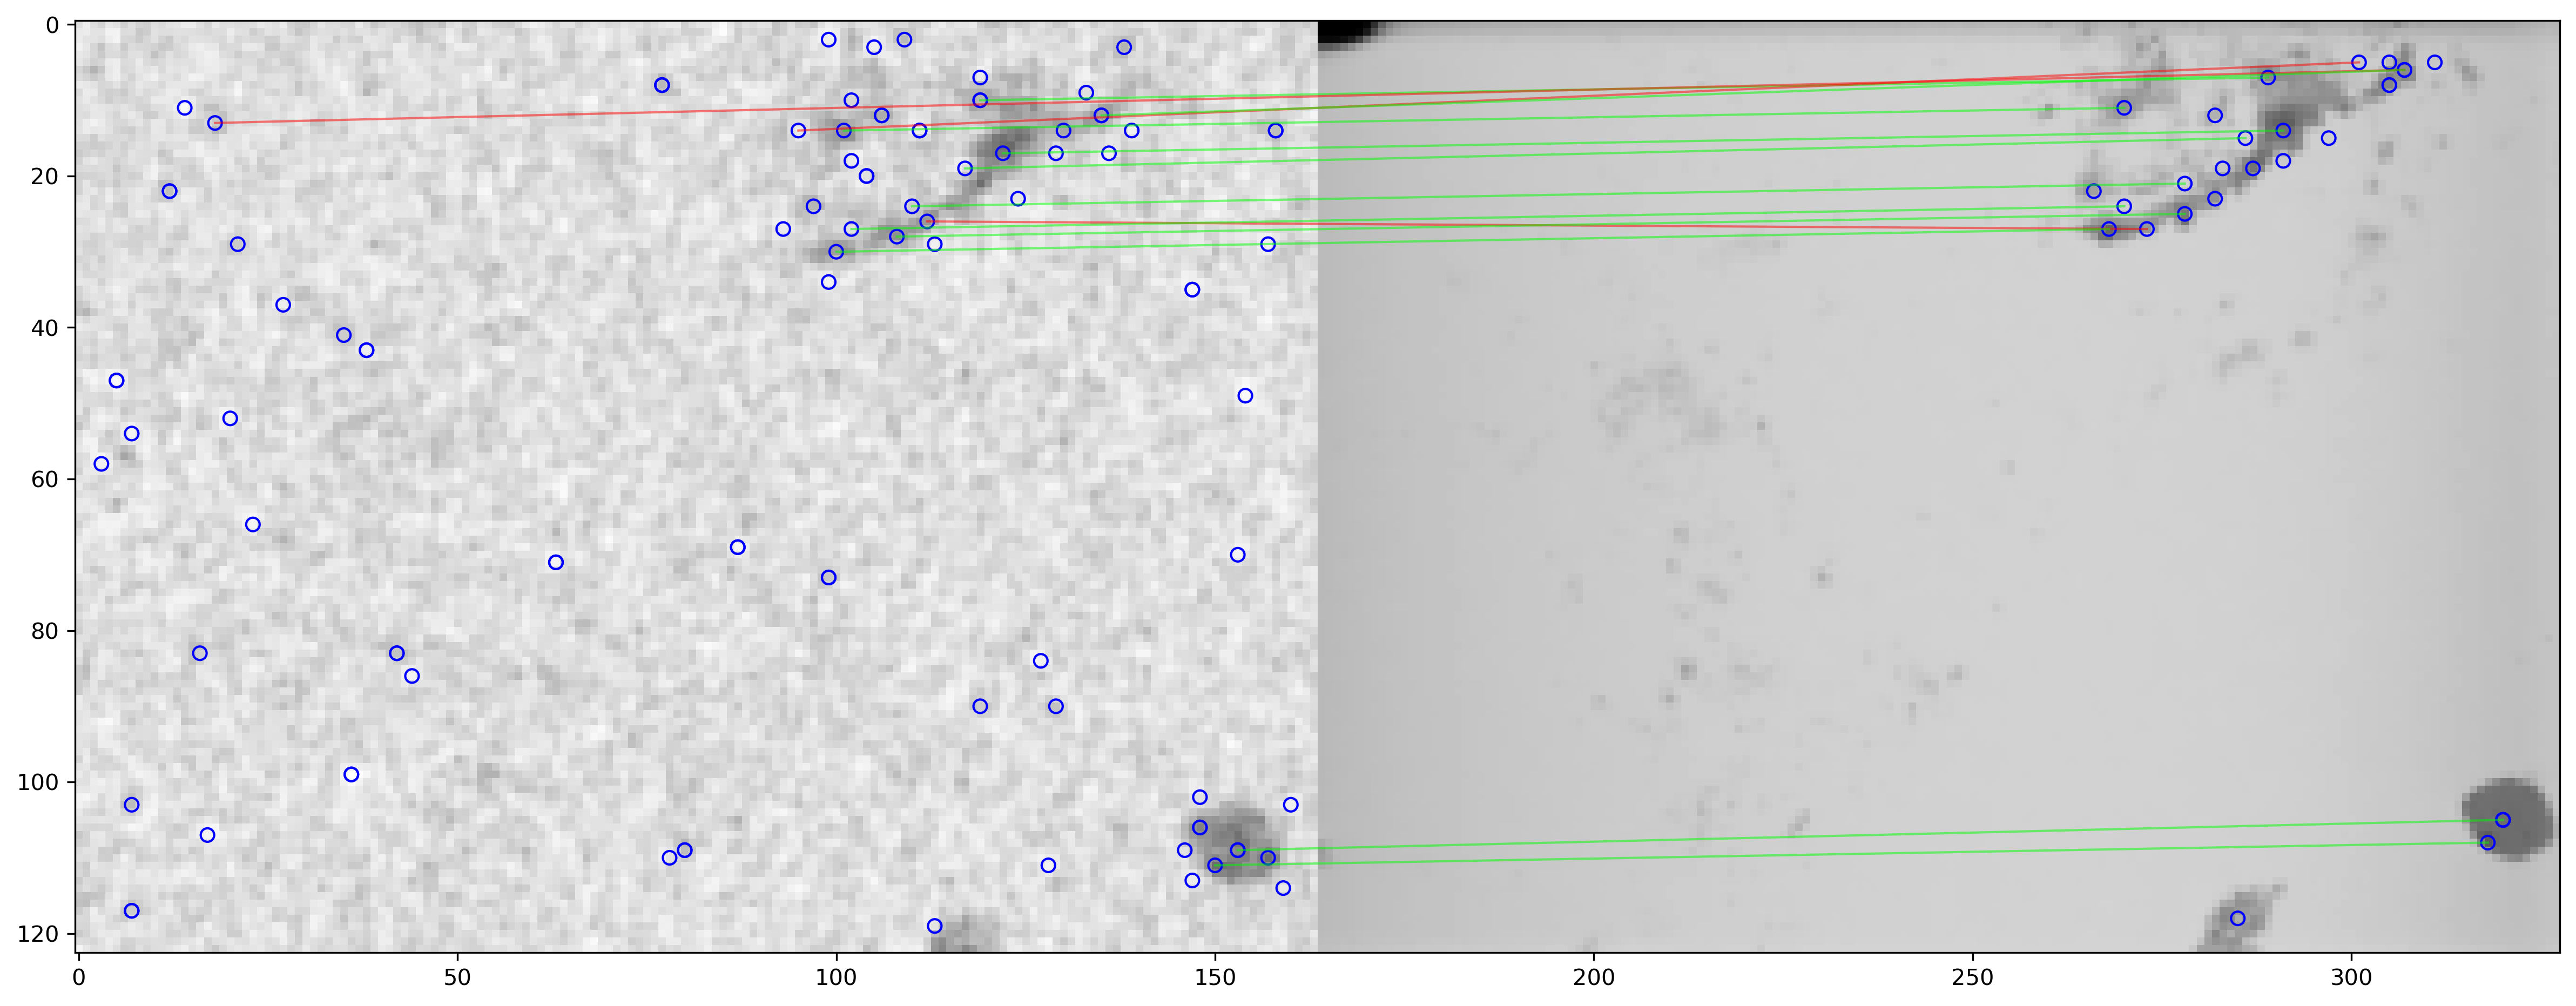

quality 0.1300591446851387
transform:
 [[ 0.99991603  0.01295884 -5.00301146]
 [-0.01295884  0.99991603  5.3915531 ]
 [ 0.          0.          1.        ]]


In [31]:
%matplotlib inline

result = pairwise_reg_func(overlap1, overlap2)
print('quality', result['quality'])
print('transform:\n', result['affine_matrix'])

## Run registration on all tiles, showing results corresponding to each tile overlap

In [32]:
%matplotlib inline
#reg.register(sims, norm_sims)